<h2>Compact Programming Language Detector Comparison</h2>
The following is a comparison of two open source libraries for Programming Language Detection.

While deciding on which two libraries I want to compare I considered the following options:

<ol>
    <li>Linguist(Github)</li>
    <li>Enry</li>
    <li>Pygments</li>
    <li>Guesslang(Microsoft/VSCode)</li>
</ol>

<b>Linguist</b> is used by Github to detect files in a repository. It's written in Ruby. It uses a number of different matching strategies to define a list of candidate languages that it feeds to the next approach in case it determined more than one candiadate. 

Enry is a golang port of Linguist which means it works virtually the same but I found it to be faster.

Pygments is primarily used as a code higlighter but it also has the capability to predict the language of a given code snippet. After trying it out on a small portion of my test data I found that it made a wrong prediction on allmost all code snippets. 

Lastly I tested out Guesslang which is used in VS-Code to automaticly predict the language of a new file. It uses a neural network to make the prediction and after testing it out I found it very promising.

I chose not to consider pygments any further because of it's bad performance on my intial test. Because Linguist and Enry deliver identical predictions it would also not make sense to compare them against eachother. In conclusion, I decided to compare <b>Guesslang against Enry</b> and the reason I chose Enry over Linguist is solely it's superior runtime. 

<h3>Imports:</h3>

In [1]:
from wrappers.guesslang_wrapper import detect_guesslang
from wrappers.enry_wrapper import detect_enry

import os
from collections import defaultdict

from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import numpy as np

<h3>Helper routines:</h3>

In [3]:
paths = defaultdict(list)  # data structure for file paths
data_path = "./test_data/" # path to test files

# load paths
for dir in os.listdir(data_path):
    for file in os.listdir(data_path + dir):
        paths[dir].append(data_path + dir + "/" + file)

ground_truth = []
paths_flat = []

# flatten paths for prediction
for k in paths:
    for p in paths[k]:
        ground_truth.append(k)
        paths_flat.append(p)

# compute accuracy of prediction
def accuracy(preds, gtruth):
    wrongly_classified_idcs = []

    for idx, t in enumerate(gtruth):
        if t != preds[idx]:
            wrongly_classified_idcs.append(idx)

    return "Accuracy: " + str(1 - len(wrongly_classified_idcs) / len(gtruth)) 

# plots confusion matrix for prediction and accuracies
def plot_conf_matrix(ground_truth, preds):
    preds_clean = [p if p in paths.keys() else "Other" for p in preds]
    labels = set(preds_clean)
    
    # clean preds
    M = confusion_matrix(ground_truth, preds_clean, normalize="true", labels=list(labels))
    
    plt.figure(figsize=(10,7))
    plt.matshow(M, cmap=plt.cm.gray_r, aspect='auto', fignum=1)
    plt.colorbar()
    tick_marks = np.arange(M.shape[0])
    plt.xticks(tick_marks, set(preds_clean), rotation=90)
    plt.yticks(tick_marks, set(preds_clean))
    plt.grid()
    
    for idx, r in enumerate(M):
        print('{:<30}{:<30}'.format(list(labels)[idx], r[idx]))

Enry has the option to supply a filename that it can use for it's prediction. While this doesn't exactly fit our usecase, we will still run it with given file extensions once to compare.
### Case 1 (File extensions given):

Enry ran in 1 seconds.
Accuracy: 0.9993144708961735
TypeScript                    1.0                           
Java                          1.0                           
Swift                         0.999                         
Julia                         1.0                           
Other                         0.0                           
Dart                          1.0                           
Python                        1.0                           
JavaScript                    0.998998998998999             
Scala                         1.0                           
Lua                           1.0                           
C                             1.0                           
Go                            1.0                           
Kotlin                        1.0                           
Clojure                       1.0                           
Ruby                          0.998998998998999             
C++                           1.0

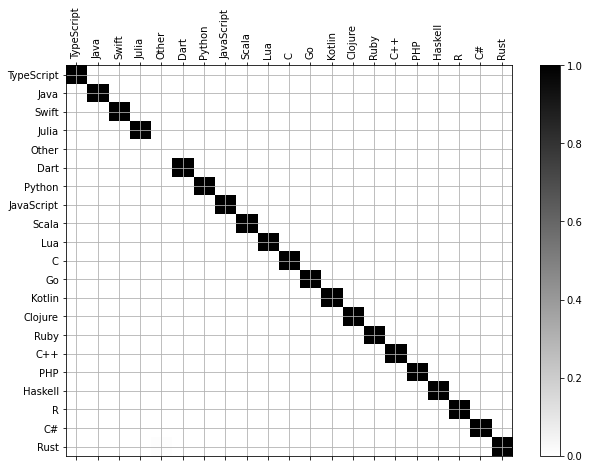

In [28]:
preds_enry = [p.decode("utf-8") for p in detect_enry(paths_flat, no_ext=False)]
print(accuracy(preds_enry, ground_truth))
plot_conf_matrix(ground_truth, preds_enry)

With file extensions given, we can see that Enty makes almost no classification errors while having a very short runtime. One would suspect that it relies heavily on the file extensions for classification but to test this we run it again without. 

### Case 2 (No file extensions): 
<font color='red'>Warning: The following cell runs for around 200 seconds</font>

Enry ran in 206 seconds.
Accuracy: 0.42147575719805563
Swift                         0.244                         
Julia                         0.01                          
Go                            0.001                         
R                             0.32974910394265233           
Lua                           0.6701570680628273            
PHP                           0.931                         
Haskell                       0.16                          
Kotlin                        0.037                         
TypeScript                    0.009009009009009009          
Scala                         0.343                         
C++                           0.727                         
C#                            0.552                         
Clojure                       0.2111716621253406            
Rust                          0.62                          
Ruby                          0.7567567567567568            
Python                        

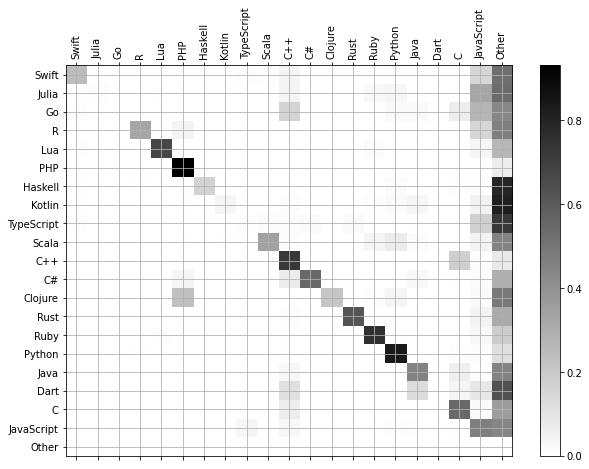

In [4]:
preds_enry_no_ext = [p.decode("utf-8") for p in detect_enry(paths_flat, no_ext=True)]
print(accuracy(preds_enry_no_ext, ground_truth))
plot_conf_matrix(ground_truth, preds_enry_no_ext)

Now it is a totally different story. The runtime is extremely long and we only have an accuracy of around 42%. Only a handfull of languages have an accuracy of above 70%. From the long runtime we can conclude that the iterative matching strategies must have mostly failed and it fell back on the naive Bayes classifier. Now lets see how Guesslang compares.

100%|██████████| 16046/16046 [00:32<00:00, 498.60it/s]


Guesslang ran in 33 seconds.
Accuracy: 0.7856163529851676
Swift                         0.525                         
Julia                         0.851                         
Go                            0.913                         
R                             0.8817204301075269            
Lua                           0.8952879581151832            
PHP                           0.969                         
Haskell                       0.95                          
Kotlin                        0.878                         
TypeScript                    0.5125125125125125            
Scala                         0.876                         
C++                           0.814                         
C#                            0.891                         
Clojure                       0.997275204359673             
Rust                          0.948                         
Ruby                          0.8548548548548549            
Python                     

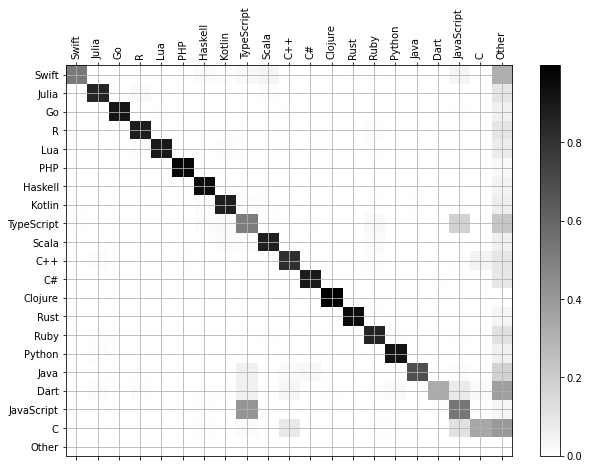

In [5]:
preds_guesslang = detect_guesslang(paths_flat)
print(accuracy(preds_guesslang, ground_truth))
plot_conf_matrix(ground_truth, preds_guesslang)

We see that it has a much better runtime and a much more reasonable accuracy of 78%. We can also observe that the classifier often times confused JavaScript for TypeScript and vice versa. This was to be expected because JavaScript is a subset of TypeScript and a valid JS programm is also a valid TS programm. In fact it's surprising that we don't observe the same phenomenon with C and C++.

<h2>Conclusion</h2>

In the Project description CPLD is defined as

<b>"... the task of guessing a programming language by looking at the snippet of source code text."</b>

so the second usecase without file extension is the one fitting for our task. Enrys performance relys heavily on wether it's matching startegies are applicable and if not so, it falls way behind Linguist in accuracy and even runtime. Because it was developed to work in a setting where file extensions are usually given (git repository), this is not much of a problem for it's original purpose but makes it less fitting for our usecase.

Guesslang has a reasonable runtime and an average acuracy of almost 80% and although it shows some confusion when it comes to differentiating between similar languages it outperforms Enry by far. This makes it the better choice in our case.